# Support Vector Machine

## マージン

データがクラス$\{C_1, C_2\}$のどちらに含まれるかを判断する2クラス識別問題について考える。

教師ラベルは$t \in \{+1, -1\}$で、それぞれデータが$C_1, C_2$のどちらに含まれるかを示すとする。
係数ベクトルを$w=(w0, w_1, ..., w_d)^T$, 特徴量ベクトルを$x=(x_0=1, x_1, ..., x_d)^T$と表すとすると、

線形識別関数は

$$
f(x) = w^T x
$$

と表すことができる。

識別境界（識別超平面）は$f(x)=0$となる位置に描かれるとし、クラス1を$f(x) >= 0$、クラス2を$f(x) < 0$で表現するように学習させるとする。例えば次の図のように、ある識別関数が存在したとする。

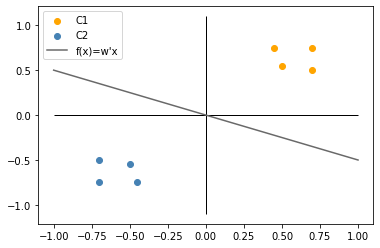

In [1]:
# 2次元に描いた場合
import numpy as np
import matplotlib.pyplot as plt

# このようなデータがあったとする
x_c1 = np.array([
    [.50, .55],
    [.45, .75],
    [.7, .50],
    [.7, .75],
])
x_c2 = - x_c1
X = np.append(x_c1, x_c2, axis=0)
y = np.array([1] * x_c1.shape[0] + [-1] * x_c2.shape[0])


# 重みベクトルが仮にこのようなwだったとする
w = np.array([1, 2])


# 描画範囲
x1 = np.linspace(-1, 1, 100)


def plot_hyperplane(X, y, w, ax, x1=x1):
    # データ点の散布図
    is_1 = y == 1
    ax.scatter(X[is_1, 0], X[is_1, 1], label="C1", color="orange")
    ax.scatter(X[~is_1, 0], X[~is_1, 1], label="C2", color="steelblue")

    # x軸, y軸を描く
    ax.hlines(0, -1, 1, colors="black", linewidth=1)
    ax.vlines(0, -1.1, 1.1, colors="black", linewidth=1)

    # 超平面：x2 = -(w1/w2) * x1の形にする
    # x1 = np.linspace(-1, 1, 100)
    x2 = -(w[0] / w[1]) * x1
    ax.plot(x1, x2, color="dimgray", label="f(x)=w'x")

    ax.legend(loc="upper left")
    return ax

fig, ax = plt.subplots()
plot_hyperplane(X, y, w, ax)
fig.show()


訓練データ中に存在しなかったノイズがテストデータに含まれていた場合、ノイズの分だけ識別を誤りやすくなる。
しかし、訓練データの点が識別超平面からある値$h > 0$よりも離れるように学習させれば、$h$より小さなノイズに対しては正しく識別できるようになる。

例えば、以下の図の(a)と(b)はいずれもサンプルをうまく分離できているものの、(a)よりも(b)のほうがデータ点と識別超平面の距離があり、ノイズに対してより頑健で望ましい分類器であると考えられる。


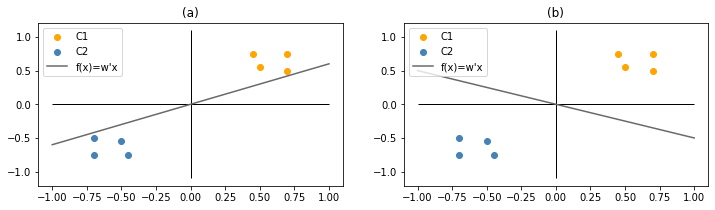

In [2]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 3))

w = np.array([-3, 5])
plot_hyperplane(X, y, w, axes[0])
axes[0].set(title="(a)")

w = np.array([1, 2])
plot_hyperplane(X, y, w, axes[1])
axes[1].set(title="(b)")

fig.show()

となれば、 **「識別超平面が訓練データからもっとも離れるように（両クラスの中間になるように）学習させればよいのではないか」** という考えが湧く。

これがサポートベクターマシン（Support Vector Machine: SVM）の考え方である。


訓練データと識別超平面との距離のことをその識別超平面の**マージン**（margin）という。

ある識別関数に対してとれるマージンの大きさは、両クラスの学習データを識別関数の法線ベクトル上に射影した長さの最小値

$$
\rho(w) = \min_{x \in C_1} \frac{w^T x}{||w||}
- \max_{x \in C_2} \frac{w^T x}{||w||}
$$

の半分である。$\rho(w)$はクラス間マージンという。次の図中の2つの破線の間の距離が$\rho(w)$である

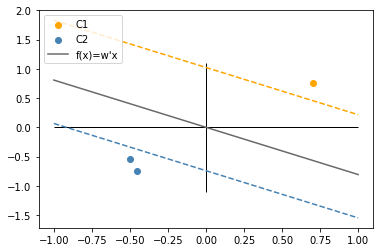

In [10]:
fig, ax = plt.subplots()
plot_hyperplane(X, y, w, ax)

# 識別関数 f(x)=w'x の下での、class={C1, C2}のどちらに属するかについての判定結果
outputs = [w.T @ X[i, :] for i in range(X.shape[0])]
is_class_1 = [o >= 0 for o in outputs]
is_class_2 = np.invert(is_class_1)

# マージンとその合計ρ
margin1 = min([(w.T @ X[is_class_1, :][i, :] / np.linalg.norm(w)) for i in range(X[is_class_1, :].shape[0])])
margin2 = max([(w.T @ X[is_class_2, :][i, :] / np.linalg.norm(w)) for i in range(X[is_class_2, :].shape[0])])
rho = margin1 - margin2

# margins
m1 = -(w[0] / w[1]) * x1 + margin1
ax.plot(x1, m1, color="orange", linestyle="--")
m2 = -(w[0] / w[1]) * x1 + margin2
ax.plot(x1, m2, color="steelblue", linestyle="--")

ax.legend(loc="upper left")
fig.show()

## ハードマージンSVM

学習データの集合を$\mathcal{D}_L = \{(t_i, x_i)\}(i=1,...,N)$とする。係数ベクトルはバイアス項$b$を外に出す形で、$w=(w_1, ..., w_d)^T$と表記する。特徴量ベクトルは$x=(x_1,...,x_d)^T$である。$t_i=\{-1, +1\}$は教師データで、学習データ$x_i\in \mathbb{R}^d$がどちらのクラスに属するかを示す。

線形識別関数のマージンを$\kappa$とすれば全ての学習データで

$$
|w^T x_i + b| \geq \kappa
$$

が成り立つ。

係数ベクトルとバイアス項をマージンで正規化（$w^T x_i = -b$を定数倍）したものをあらためて$w, b$とおけば

$$
\begin{cases}
w^T x_i + b \geq +1  & \text{if} \hspace{0.5em} t_i = +1\\
w^T x_i + b \leq -1  & \text{if} \hspace{0.5em} t_i = -1
\end{cases}
$$

となり、まとめて表記すると

$$
t_i \times (w^T x_i + b) \geq 1
$$


クラス間マージンは
$$
\rho(w, b)
= \min_{x \in C_{y=+1}} \frac{w^T x}{||w||} - \max_{x\in C_{y=-1}} \frac{w^T x}{||w||}
$$

第1項の分子は$w^T x_i + b \geq +1$の最小値が$w^T x_i + b = 1$であることから$\min w^T x_i = 1 - b$

第2項の分子は$w^T x_i + b \leq -1$の最大値が$w^T x_i + b = -1$であることから$\max w^T x_i = -1 - b$

であることを使えば


$$
\begin{align}
\rho(w, b)
&= \min_{x \in C_{y=+1}} \frac{w^T x}{||w||} - \max_{x\in C_{y=-1}} \frac{w^T x}{||w||}\\
&= \frac{1 - b}{||w||} - \frac{-1 - b}{||w||}\\
&= \frac{1 + 1 - b + b}{||w||}\\
&= \frac{2}{||w||}
\end{align}
$$

となる。

識別関数の最大マージンは最大クラス間マージンの半分であるため、$\frac{1}{||w||}$となる。


### 最適識別超平面

最適な識別超平面は、「すべての訓練データを正しく識別できる」という制約条件

$$
t_i (w^T x_i + b) \geq 1 \hspace{1em} (i=1,...,N)
$$

の下で係数ベクトルのノルム$||w||$を最小にする解

$$
w_0 = \min ||w||
$$

として求めることができる。これは次の不等式制約条件つき最適化問題を解くことで得られる。


:::{admonition} 主問題
$$
\begin{align}
\text{minimize} & \hspace{1em} L_p(w) = \frac{1}{2} w^T w\\
\text{subject to} & \hspace{1em} t_i( w^T x_i + b) \geq 1; \ \forall i
\end{align}
$$
:::

この問題はラグランジュの未定乗数法を用いて解かれ、次のラグランジュ関数として定式化される

$$
\tilde{L}_p(w, b, \alpha) = \frac{1}{2} w^T w
- \sum^N_{i=1} \alpha_i (t_i (w^T x_i + b) - 1)
$$

ここで$\alpha=(\alpha_1, ..., \alpha_N)^T$、$\alpha_i \geq 0$であり、$\alpha_i$はラグランジュ未定乗数と呼ばれる。

この最適化問題の解$w_*$と$b_*$は以下の**KKT（Karush-Kuhn-Tucker）条件**を満たす解として知られている。

:::{admonition} KKT条件

(1) $\displaystyle \frac{\partial \tilde{L}_p(w, b, \alpha)}{\partial w}|_{w=w_*} = w_* - \sum^N_{i=1} \alpha_i t_i x_i = 0$

(2) $\displaystyle \frac{\partial \tilde{L}_p(w, b, \alpha)}{\partial b} = \sum^N_{i=1} \alpha_i t_i = 0$

(3) $t_i(w^T x_i + b) - 1 \geq 0$

(4) $\alpha_i \geq 0$

(5) $\alpha_i (t_i (w^T x_i + b) - 1) = 0$

:::

ラグランジュ関数の$w$を$w_*$に置き換えてKKT条件(1)と(2)を代入して整理すると

$$
\begin{align}
L_d(\alpha)
&= \frac{1}{2} {w_*}^T w_* - \sum^N_{i=1} \alpha_i t_i w_*^T x_i - b \sum^N_{i=1} \alpha_i t_i + \sum^N_{i=1} \alpha_i\\
&= \sum^N_{i=1} \alpha_i - \frac{1}{2} w_*^T w_*  \hspace{2em} (\because \sum^N_{i=1} \alpha_i t_i = 0)\\
&= \sum^N_{i=1} \alpha_i - \frac{1}{2} \sum^N_{i=1} \sum^N_{j=1} \alpha_i \alpha_j t_i t_j x_i^T x_j
\end{align}
$$

となり、ラグランジュ未定乗数のみの関数にすることができる

KKT条件(1)より最適解は$w_* = \sum^N_{i=1} \alpha_i t_i x_i$のようになることがわかっているので、最適な係数$\alpha_i$を求める問題に置き換えることができる。

:::{admonition} 双対問題
$$
\begin{align}
\text{maximize} & \hspace{1em} L_d(\alpha) = \alpha^T \boldsymbol{1} - \frac{1}{2} \alpha^T H \alpha \\
\text{subject to} & \hspace{1em} \alpha^T t = 0
\end{align}
$$
:::

ここで

$$
\begin{align}
\boldsymbol{1} &= (1,...,1)^T\\
H &= (H_{ij} = t_i t_j x_i^T x_j)\\
t &= (t_1,...,t_N)^T\\
\end{align}
$$

である。

双対問題のラグランジュ関数は、ラグランジュ未定乗数を$\beta$とすれば次の関数になる。

$$
\tilde{L}_d(\alpha, \beta) = \alpha^T \boldsymbol{1} - \frac{1}{2} \alpha^T H \alpha - \beta \alpha^T t
$$


KKT条件(5)より$\alpha_i (t_i (w^T x_i + b) - 1) = 0$がすべての$i$で成り立てば良いため、

$$
\begin{cases}
\alpha_i > 0 & \text{if} \hspace{0.5em} t_i(w^T x_i + b) - 1 = 0\\
\alpha_i = 0 & \text{if} \hspace{0.5em} t_i(w^T x_i + b) - 1 \neq 0
\end{cases}
$$

となる。$\alpha_i > 0$となる$x_i$を**サポートベクトル**という。

最適なバイアス$b_*$はサポートベクトルの一つ$x_s$を用いて

$$
t_s (w_*^T x_s + b_*) - 1 = 0
$$

を解いて求めるか、それらの平均を用いる。

### 実装例（cvxpy）

双対問題を[cvxpyの二次計画問題のソルバー](https://www.cvxpy.org/examples/basic/quadratic_program.html)を使って解いてみる

In [4]:
# データ数が多くなるとソルバーが上手く動かないので一旦暫定的対処としてデータ数を絞る
y = y[3:6]
X = X[3:6]

In [7]:
t = y
# Hを作成
n = X.shape[0]
H = np.zeros(shape=(n, n))
for i in range(n):
    for j in range(n):
        H[i, j] = t[i] * t[i] * X[i] @ X[j]

ones = np.ones(shape=(n, ))

In [8]:
import cvxpy as cp

alpha = cp.Variable(n)  # 長さnのベクトル
prob = cp.Problem(cp.Maximize( alpha.T @ ones - (1/2) * cp.quad_form(alpha, H) ),
                  [alpha.T @ t == 0])
prob.solve()
print("The optimal value is", prob.value)
print("alpha is", alpha.value)

a = alpha.value
w = sum([a[i] * t[i] * X[i] for i in range(n)])
print(f"w={w}")

The optimal value is 33.99999999999996
alpha is [34. 10. 24.]
w=[39.6 49. ]


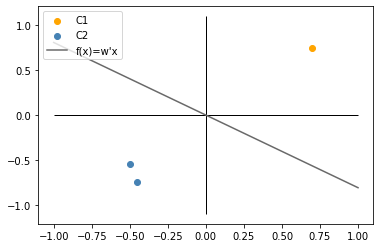

In [9]:
fig, ax = plt.subplots()
plot_hyperplane(X, y, w, ax)
fig.show()

### 実装例（scikit-learn）

In [5]:
from sklearn import svm
clf = svm.SVC(random_state=0, kernel='linear', shrinking=False)
clf.fit(X, y)

print(f"b={clf.intercept_}, w={clf.coef_}")

b=[-0.15974441], w=[[0.76677316 0.83067093]]


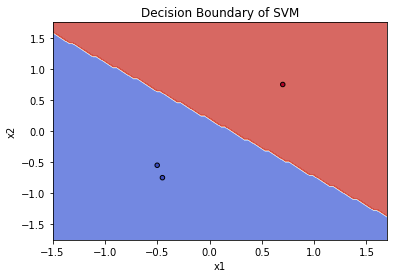

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay
fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.8,
    ax=ax,
    xlabel="x1",
    ylabel="x2",
)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set(title="Decision Boundary of SVM")
fig.show()

# ソフトマージンSVM

In [13]:
# TODO

### ν-SVM

上限サポートベクトル（マージン誤り$\xi_i > 0$のベクトルの数）の割合の上限を規定するハイパーパラメータ$\nu$が指定できるようになった

# カーネルトリック

In [12]:
# TODO